In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor 

MAE  : 341
RMSE : 509
Moyenne du CA sur la periode : 1540
Pourcentage MAE : 22%


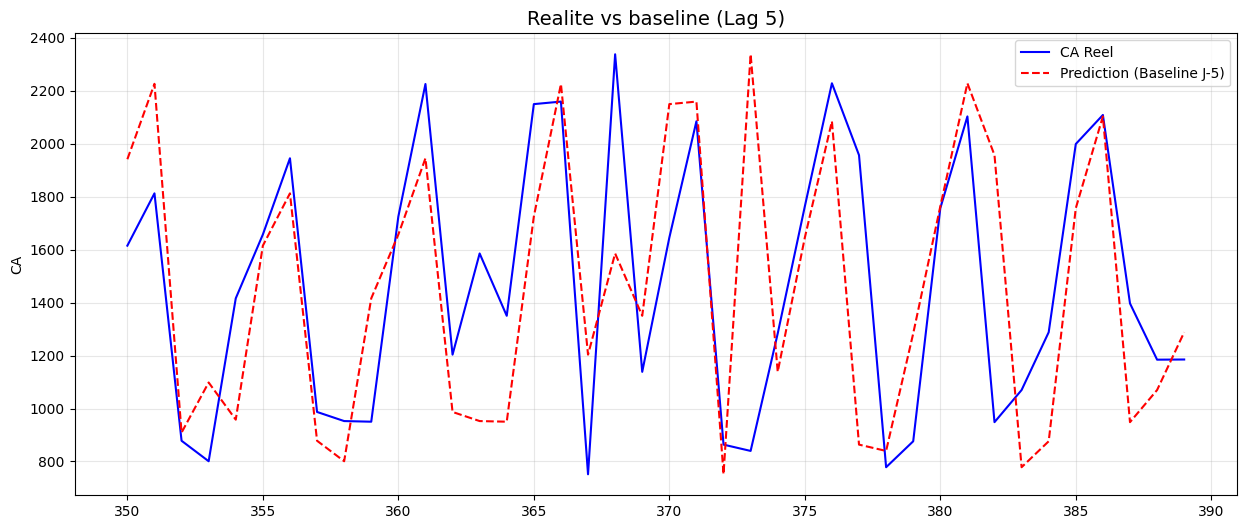

In [2]:
#Baseline Model (Lag 5)

df = pd.read_csv("SalesDATA.csv")

#baseline
df["baseline_pred"] = df["CA"].shift(5)


#Train Test Split 80/20
split = int(len(df) * 0.8)
train = df.iloc[:split]
test = df.iloc[split:]

#MAE and RMSE
mae_bl = mean_absolute_error(test["CA"], test["baseline_pred"])
rmse_bl = np.sqrt(mean_squared_error(test["CA"], test["baseline_pred"]))

print("MAE  : " + str(int(mae_bl)))
print("RMSE : " + str(int(rmse_bl)))

Moyenne_CA = test["CA"].mean()
print("Moyenne du CA sur la periode : " + str(int(Moyenne_CA)))
print("Pourcentage MAE : " + str(int((mae_bl/Moyenne_CA)*100)) + "%")


#last 60 days
zoom_test = test.tail(40)
plt.figure(figsize=(15, 6))

#reality
plt.plot(zoom_test.index, zoom_test["CA"], label="CA Reel", color="blue")

#baseline lag 5
plt.plot(zoom_test.index, zoom_test["baseline_pred"], label="Prediction (Baseline J-5)", linestyle="--", color="red")

plt.title("Realite vs baseline (Lag 5)", fontsize=14)
plt.ylabel("CA")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
#creating features dataframe

df_features = df.copy()

#weekly seasonality
df_features["lag_5"] = df_features["CA"].shift(5)
#daily seasonality
df_features["lag_1"] = df_features["CA"].shift(1)

#moving average
df_features["CA_lisse_5"] = df_features["CA"].rolling(window=5).mean().shift(1)

#date features
df_features["Date"] = pd.to_datetime(df_features["Date"])
df_features["mois"] = df_features["Date"].dt.month
df_features["jour_semaine"] = df_features["Date"].dt.dayofweek  #0=monday 6=sunday
df_features["jour_mois"] = df_features["Date"].dt.day

print(df_features[["CA", "lag_1", "lag_5", "CA_lisse_5", "jour_semaine", "mois", "jour_mois"]].head(10))#head(10) to see lag5 and moving_avg5

        CA    lag_1    lag_5  CA_lisse_5  jour_semaine  mois  jour_mois
0  1535.00      NaN      NaN         NaN             2     7          5
1  1017.15  1535.00      NaN         NaN             3     7          6
2   994.90  1017.15      NaN         NaN             4     7          7
3  1710.30   994.90      NaN         NaN             5     7          8
4  2081.01  1710.30      NaN         NaN             6     7          9
5  1424.22  2081.01  1535.00    1467.672             2     7         12
6  1653.91  1424.22  1017.15    1445.516             3     7         13
7  1529.50  1653.91   994.90    1572.868             4     7         14
8  2054.20  1529.50  1710.30    1679.788             5     7         15
9  1775.10  2054.20  2081.01    1748.568             6     7         16


In [11]:
#XGBoost model 

df_XGB = df_features.copy()

#features
features = ["lag_1", "lag_5", "CA_lisse_5", "jour_semaine"]
target = "CA"

X = df_XGB[features]
y = df_XGB[target]

#train test split
split_point = int(len(df_XGB) * 0.8)

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

#XGBoost model with best parameters (last cell)
model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, early_stopping_rounds=50,max_depth=3)

model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

#predictions
predictions_xgb = model_xgb.predict(X_test)

#Results
print("XGBoost Results : \n")
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mape_xgb = np.mean(np.abs((y_test - predictions_xgb) / y_test)) * 100
print("MAE XGBoost : " + str(int(mae_xgb)))
print("RMSE XGBoost : " + str(int(rmse_xgb)))
Moyenne_CA = df_XGB["CA"].mean()
print("MAPE XGBoost : " + str(int((mae_xgb / Moyenne_CA) * 100)) + "%\n")

#feature importance
importance = model_xgb.get_booster().get_score(importance_type='gain')
total_gain = sum(importance.values())


#feature importance
print("Feature Importance : \n")
for feature, score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
    percentage = (score / total_gain) * 100
    print(feature + " : " + str(int(percentage)) + "%")

XGBoost Results : 

MAE XGBoost : 264
RMSE XGBoost : 371
MAPE XGBoost : 16%

Feature Importance : 

jour_semaine : 82%
lag_1 : 7%
lag_5 : 5%
CA_lisse_5 : 4%


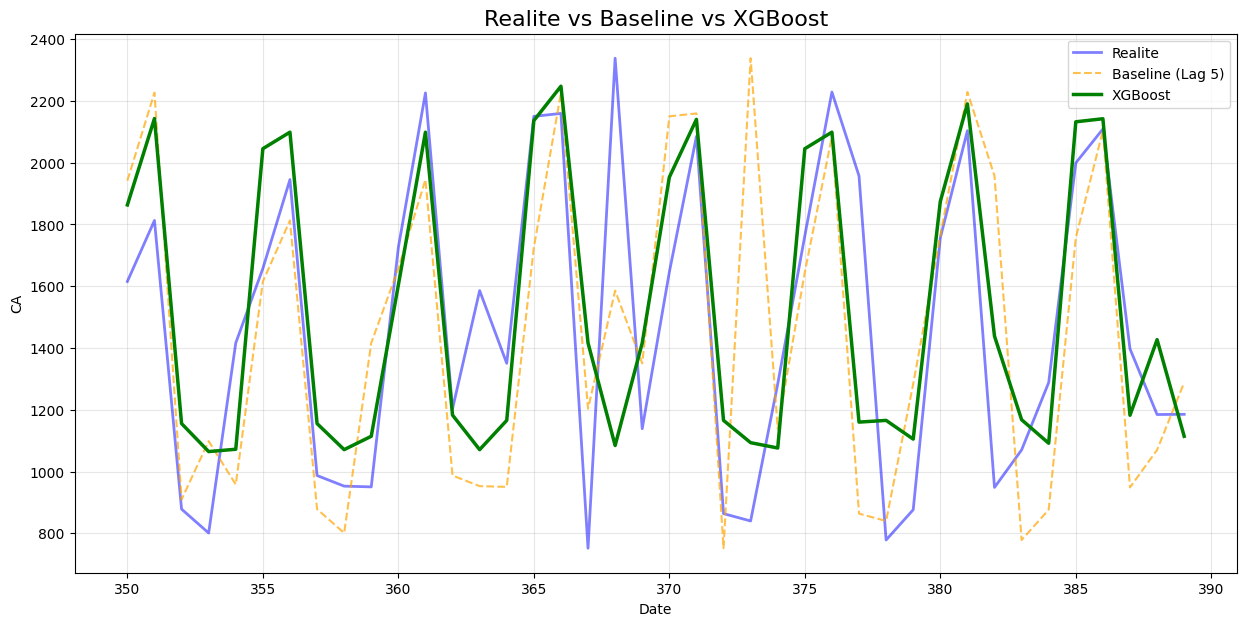

In [5]:
#Baseline vs XGBoost vs Reality 

zoom_test = y_test.tail(40).to_frame(name="CA_Reel")
zoom_test["Pred_Baseline"] = df_XGB.loc[zoom_test.index, "lag_5"] # On récupère la baseline
zoom_test["Pred_XGBoost"] = predictions_xgb[-40:] # On récupère les prédictions XGBoost

plt.figure(figsize=(15, 7))

#real 
plt.plot(zoom_test.index, zoom_test["CA_Reel"], label="Realite", color="blue", alpha=0.5, linewidth=2)

#baseline lag5
plt.plot(zoom_test.index, zoom_test["Pred_Baseline"], label="Baseline (Lag 5)", color="orange", linestyle="--", alpha=0.7)

#XGBoost
plt.plot(zoom_test.index, zoom_test["Pred_XGBoost"], label="XGBoost", color="green", linewidth=2.5)

plt.title("Realite vs Baseline vs XGBoost", fontsize=16)
plt.xlabel("Date")
plt.ylabel("CA")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#XGBoostCross Validation

#nb of month to test
nb_mois_test = 4
scores_mae = []
scores_mape = []

#get month
mois = df_features["Date"].dt.to_period("M").unique()
derniers_mois = mois[-nb_mois_test:] 


#loop for every month to predict on different test periods
for mois_cible in derniers_mois:
    #testing period
    date_debut_test = mois_cible.start_time
    date_fin_test = mois_cible.end_time

    #train and test mask
    train_mask = df_features["Date"] < date_debut_test
    test_mask = (df_features["Date"] >= date_debut_test) & (df_features["Date"] <= date_fin_test)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    #training
    model_cv = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, early_stopping_rounds=50, max_depth=3)
    model_cv.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    #predictions
    pred = model_cv.predict(X_test)
    
    #MAE and RMSE
    mae = mean_absolute_error(y_test, pred)
    
    #monthly MAPE
    moyenne_CA_mensuelle = np.mean(y_test)
    mape_mensuelle = (mae / moyenne_CA_mensuelle) * 100
    
    #add to lists
    scores_mae.append(mae)
    scores_mape.append(mape_mensuelle)
    
    print("Test "  + str(mois_cible) + " MAE: " + str(int(mae)) + "€ | MAPE: " + str(int(mape_mensuelle)) + "%")

print("\nMoyenne MAE :" + str(int(np.mean(scores_mae))) + " €")
print("Moyenne MAPE :" + str(int(np.mean(scores_mape))) + "%")


Test 2025-01 MAE: 375€ | MAPE: 20%
Test 2025-02 MAE: 215€ | MAPE: 16%
Test 2025-03 MAE: 288€ | MAPE: 18%
Test 2025-04 MAE: 153€ | MAPE: 11%

Moyenne MAE :258 €
Moyenne MAPE :16%


In [7]:
#Random forest model 

#nb of month to test
nb_mois_test = 4
scores_mae_rf = []
scores_mape_rf = []

#get month
mois_disponibles = df_features["Date"].dt.to_period("M").unique()
derniers_mois = mois_disponibles[-nb_mois_test:] 

#loop
for mois_cible in derniers_mois:
    date_debut_test = mois_cible.start_time
    date_fin_test = mois_cible.end_time
    
    train_mask = df_features["Date"] < date_debut_test
    test_mask = (df_features["Date"] >= date_debut_test) & (df_features["Date"] <= date_fin_test)
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    #RandomForest model 
    model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
    model_rf.fit(X_train, y_train)
    
    #predictions
    preds_rf = model_rf.predict(X_test)
    
    mae_rf = mean_absolute_error(y_test, preds_rf)
    mape_mensuelle = np.mean(np.abs((y_test - preds_rf) / y_test)) * 100
    
    scores_mae_rf.append(mae_rf)
    scores_mape_rf.append(mape_mensuelle)
    
    print("Test "  + str(mois_cible) + " MAE: " + str(int(mae_rf)) + "€ | MAPE: " + str(int(mape_mensuelle)) + "%")

print("\nMoyenne MAE Random Forest : " + str(int(np.mean(scores_mae_rf))) + "€")
print("Moyenne MAPE Random Forest : " + str(int(np.mean(scores_mape_rf))) + "%")

Test 2025-01 MAE: 423€ | MAPE: 23%
Test 2025-02 MAE: 296€ | MAPE: 24%
Test 2025-03 MAE: 322€ | MAPE: 21%
Test 2025-04 MAE: 246€ | MAPE: 20%

Moyenne MAE Random Forest : 322€
Moyenne MAPE Random Forest : 22%


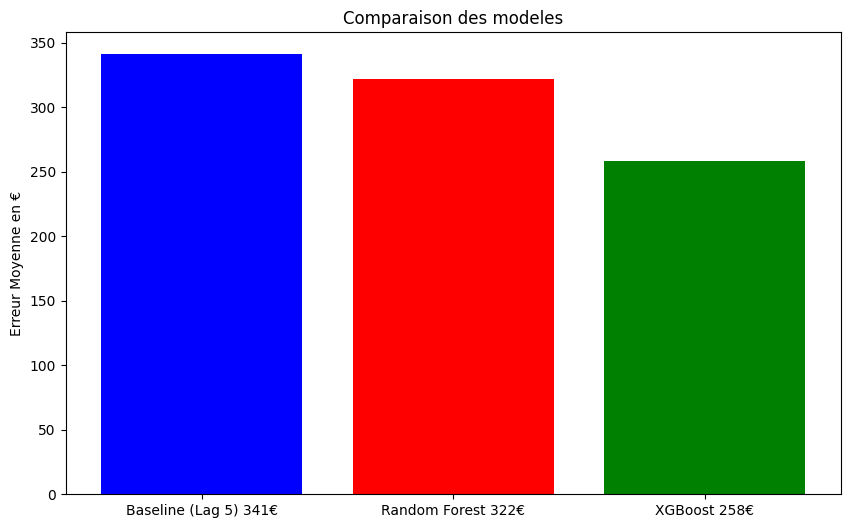

In [8]:
#Model comparison 


mae_bl = 341
mae_rf = 322
mae_xgb = 258
modeles = ["Baseline (Lag 5) " + str(mae_bl) + "€" , "Random Forest " + str(mae_rf) + "€", "XGBoost " + str(mae_xgb) + "€"]

plt.figure(figsize=(10, 6))
bars = plt.bar(modeles, [mae_bl, mae_rf, mae_xgb], color=["blue", "red", "green"])


plt.title("Comparaison des modeles")
plt.ylabel("Erreur Moyenne en €")
plt.show()

XGBoost is the best model for this dataset


In [9]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

#Finding best parameters for XGBoost

#different parameters
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [500, 1000, 1500]
}

#XGB model
xgb_model = xgb.XGBRegressor(early_stopping_rounds=None)
ts_split = TimeSeriesSplit(n_splits=3)

#Gridsearch
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=ts_split, scoring="neg_mean_absolute_error", verbose=1)
grid_search.fit(X, y)

#best parameters
best_params = grid_search.best_params_
print("Meilleurs parametres : " + str(best_params))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Meilleurs parametres : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
